# Deep Learning in Medicine Final Project - Deep Learning Methods for Wearable Sleep Staging

# Imports and Defintions

## Library Imports

In [1]:
import os
import numpy as np
import seaborn as sns
import optuna
import pandas as pd
import matplotlib.pyplot as plt
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from torchmetrics.classification import MulticlassCohenKappa
from IPython.display import clear_output
import pytorch_lightning as pl
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, cohen_kappa_score, confusion_matrix, roc_auc_score
from collections import Counter
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers.wandb import WandbLogger
import wandb

torch.set_float32_matmul_precision('medium')

## Helper functions

In [2]:
def safe_float(x): # Helper to safely convert strings to floats
    try:
        return float(x)
    except:
        return np.nan


def forward_fill(x: torch.Tensor): # Forward‑fill NaNs in each channel
    single = False
    if x.dim() == 1:
        x = x.unsqueeze(1)
        single = True
    T, C = x.shape
    for c in range(C):
        if torch.isnan(x[0, c]):
            x[0, c] = 0.0
        for t in range(1, T):
            if torch.isnan(x[t, c]):
                x[t, c] = x[t - 1, c]
    return x.squeeze(1) if single else x

## Dataset Class

In [3]:
class DualFreqDataset(Dataset):
    def __init__(self,
                 subjects_list,
                 data_dir,
                 chunk_duration: float = 600,
                 chunk_stride: float = 300,
                 high_freq: int = 32,
                 low_freq: int = 8,
                 hf_features: list = None,
                 lf_features: list = None,
                 debug: bool = False):
        self.hf_downsample = int(64 // high_freq) # downsample factor for high frequency data
        self.lf_downsample = int(64 // low_freq) # downsample factor for low frequency data

        SLEEP_STAGE_MAPPING = {
            "W": 0,    # Wake
            "N1": 1,   # non-REM stage 1 (light sleep_)
            "N2": 1,   # non-REM stage 2 (light sleep)
            "N3": 2,   # non-REM stage 3 (deep sleep)
            "R": 3,    # REM
            "Missing": -1  # Missing label → ignore
        }
        numeric_columns = ['TIMESTAMP', 'BVP', 'ACC_X', 'ACC_Y', 'ACC_Z', 'TEMP', 'EDA', 'HR', 'IBI']
        converters = {col: safe_float for col in numeric_columns}

        self.chunks = []
        for SID in subjects_list:
            path = os.path.join(data_dir, f"{SID}_whole_df.csv")
            if not os.path.exists(path):
                raise FileNotFoundError(f"File {path} does not exist.")
            # Load data for subject
            df = pd.read_csv(path,
                             dtype={'Sleep_Stage': 'category'},
                             converters=converters,
                             low_memory=True)
            
            # drop preparation phase, map labels
            df = df[df['Sleep_Stage'] != 'P']
            df['Sleep_Stage'] = df['Sleep_Stage'].astype(str).str.strip()
            labels_arr = (
                df['Sleep_Stage']
                  .map(SLEEP_STAGE_MAPPING)
                  .fillna(-1)
                  .astype(int)
                  .to_numpy()
            )
            # combine ACC_X, ACC_Y, ACC_Z into a single feature
            df['ACC'] = np.sqrt(df['ACC_X']**2 + df['ACC_Y']**2 + df['ACC_Z']**2)
            # separate high and low frequency data
            df_high = df[hf_features].copy()
            df_low = df[lf_features].copy()
            # downsample data and labels
            df_high = df_high.iloc[::self.hf_downsample, :].reset_index(drop=True)
            df_low = df_low.iloc[::self.lf_downsample, :].reset_index(drop=True)
            labels_arr = labels_arr[::self.lf_downsample]
            # normalize data
            df_high = (df_high - df_high.mean()) / (df_high.std().replace(0, 1e-6))
            df_low = (df_low - df_low.mean()) / (df_low.std().replace(0, 1e-6))
            # create chunks
            total_time = int(len(df_high) / high_freq)
            n_chunks = int((total_time - chunk_duration) // chunk_stride) + 1
            for i in range(n_chunks):
                start_time = i * chunk_stride
                end_time = start_time + chunk_duration
                
                start_low = int(start_time * low_freq)
                end_low = int(end_time * low_freq)
                start_high = int(start_time * high_freq)
                end_high = int(end_time * high_freq)

                lf_chunk = df_low .iloc[start_low: end_low ].values.astype(np.float32)
                hf_chunk = df_high.iloc[start_high:end_high].values.astype(np.float32)
                labels_chunk = labels_arr[start_low: end_low]

                lf_chunk = forward_fill(torch.tensor(lf_chunk, dtype=torch.float32))
                hf_chunk = forward_fill(torch.tensor(hf_chunk, dtype=torch.float32))
                labels_chunk = torch.tensor(labels_chunk, dtype=torch.long)
                
                if (labels_chunk != -1).any():
                    self.chunks.append({
                        'high': hf_chunk,
                        'low': lf_chunk,
                        'labels': labels_chunk,
                    })
        if debug:
            print(f"Loaded {len(self.chunks)} chunks from {len(subjects_list)} subjects.")
    def __len__(self):
        return len(self.chunks)
    def __getitem__(self, idx):
        chunk = self.chunks[idx]
        hf = chunk['high']
        lf = chunk['low']
        labels = chunk['labels']
        return hf, lf, labels

## Optuna objectives

### LSTM Objective

In [4]:
def lstm_objective(trial):
    # Define the hyperparameters to optimize
    hf_input_channels = len(hf_features)
    lf_input_channels = len(lf_features)
    lstm_hidden_size = trial.suggest_categorical("lstm_hidden_size", [32, 64, 128, 256])
    lstm_num_layers = trial.suggest_categorical("lstm_num_layers",[2,4,6])
    dropout = trial.suggest_float('dropout', 0.1, 0.5)
    num_sleep_stages = 4
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)
    weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-2, log=True)
    label_smoothing = trial.suggest_float('label_smoothing', 0.0, 0.3)

    # create the logger and callbacks
    wandb_logger = WandbLogger(
        project="LSTM-Sleep-Stager",
        name=f"optuna-{trial.number}",
        log_model=True,
        save_dir="wandb_logs"
    )
    checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath='checkpoints/LSTM/Optuna',
    filename='best-checkpoint',
    save_top_k=1,
    mode='min'
    )
    early_stop_callback = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=True,
    mode='min'
    )
    # Create the model
    model = LSTMSleepStager(
        hf_input_channels=hf_input_channels,
        lf_input_channels=lf_input_channels,
        lstm_hidden_size=lstm_hidden_size,
        lstm_num_layers=lstm_num_layers,
        lstm_bidirectional=True,
        dropout=dropout,
        num_sleep_stages=num_sleep_stages,
        learning_rate=learning_rate,
        weight_decay=weight_decay,
        label_smoothing=label_smoothing,
        weight_tensor=torch.tensor(class_weights, dtype=torch.float32),
        debug=False
    )

    # Define the trainer
    trainer = pl.Trainer(
    max_epochs=10,
    devices=1,
    accelerator='gpu',
    logger=wandb_logger,
    callbacks=[checkpoint_callback, early_stop_callback],
    log_every_n_steps=1,
    precision="16-mixed",
    )

    # Train the model
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
    trainer.fit(model, train_loader, val_loader)

    # return best val loss
    best_val_loss = checkpoint_callback.best_model_score.item()
    
    wandb.finish()
    clear_output()
    return best_val_loss

### TCN Only Objective

In [5]:
def tcn_objective(trial):
    # Define the hyperparameters to optimize
    hf_input_channels = len(hf_features)
    lf_input_channels = len(lf_features)
    cnn_output_channels = trial.suggest_categorical("cnn_output_channels", [8, 16, 32, 64, 128])
    dropout = trial.suggest_float('dropout', 0.1, 0.5)
    num_sleep_stages = 4
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)
    weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-2, log=True)
    label_smoothing = trial.suggest_float('label_smoothing', 0.0, 0.3)
    num_tcn_blocks = trial.suggest_int("num_tcn_blocks", 3, 8)
    tcn_kernel_size = trial.suggest_categorical("tcn_kernel_size", [3, 5, 7])

    # create the logger and callbacks
    wandb_logger = WandbLogger(
        project="TCN-Sleep-Stager",
        name=f"optuna-{trial.number}",
        log_model=True,
        save_dir="wandb_logs"
    )
    checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath='checkpoints/TCN/Optuna',
    filename='best-checkpoint',
    save_top_k=1,
    mode='min'
    )
    early_stop_callback = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=True,
    mode='min'
    )
    # Create the model
    model = ConvSleepStager(
        hf_input_channels=hf_input_channels,
        lf_input_channels=lf_input_channels,
        cnn_output_channels=cnn_output_channels,
        dropout=dropout,
        num_sleep_stages=num_sleep_stages,
        learning_rate=learning_rate,
        weight_decay=weight_decay,
        label_smoothing=label_smoothing,
        weight_tensor=torch.tensor(class_weights, dtype=torch.float32),
        convnet='TCN',
        num_tcn_blocks=num_tcn_blocks,
        tcn_kernel_size=tcn_kernel_size,
        debug=False
    )

    # Define the trainer
    trainer = pl.Trainer(
    max_epochs=10,
    devices=1,
    accelerator='gpu',
    logger=wandb_logger,
    callbacks=[checkpoint_callback, early_stop_callback],
    log_every_n_steps=1,
    precision="16-mixed",
    )

    # Train the model
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
    trainer.fit(model, train_loader, val_loader)

    # return best val loss
    best_val_loss = checkpoint_callback.best_model_score.item()
    
    wandb.finish()
    clear_output()
    return best_val_loss

### TCN-LSTM Objective

In [6]:
def tcn_lstm_objective(trial):
    # Define the hyperparameters to optimize
    hf_input_channels = len(hf_features)
    lf_input_channels = len(lf_features)
    cnn_output_channels = trial.suggest_categorical("cnn_output_channels", [8, 16, 32, 64, 128])
    lstm_hidden_size = trial.suggest_categorical("lstm_hidden_size", [32, 64, 128, 256])
    lstm_num_layers = trial.suggest_categorical("lstm_num_layers",[2,4,6])
    dropout = trial.suggest_float('dropout', 0.1, 0.5)
    num_sleep_stages = 4
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)
    weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-2, log=True)
    label_smoothing = trial.suggest_float('label_smoothing', 0.0, 0.3)
    num_tcn_blocks = trial.suggest_int("num_tcn_blocks", 3, 8)
    tcn_kernel_size = trial.suggest_categorical("tcn_kernel_size", [3, 5, 7])

    # create the logger and callbacks
    wandb_logger = WandbLogger(
        project="TCN-LSTM-Sleep-Stager",
        name=f"optuna-{trial.number}",
        log_model=True,
        save_dir="wandb_logs"
    )
    checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath='checkpoints/TCN-LSTM/Optuna',
    filename='best-checkpoint',
    save_top_k=1,
    mode='min'
    )
    early_stop_callback = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=True,
    mode='min'
    )
    # Create the model
    model = DualFreqSleepStager(
        hf_input_channels=hf_input_channels,
        lf_input_channels=lf_input_channels,
        cnn_output_channels=cnn_output_channels,
        lstm_hidden_size=lstm_hidden_size,
        lstm_num_layers=lstm_num_layers,
        lstm_bidirectional=True,
        dropout=dropout,
        num_sleep_stages=num_sleep_stages,
        learning_rate=learning_rate,
        weight_decay=weight_decay,
        label_smoothing=label_smoothing,
        weight_tensor=torch.tensor(class_weights, dtype=torch.float32),
        convnet='TCN',
        num_tcn_blocks=num_tcn_blocks,
        tcn_kernel_size=tcn_kernel_size,
        debug=False
    )

    # Define the trainer
    trainer = pl.Trainer(
    max_epochs=10,
    devices=1,
    accelerator='gpu',
    logger=wandb_logger,
    callbacks=[checkpoint_callback, early_stop_callback],
    log_every_n_steps=1,
    precision="16-mixed",
    )

    # Train the model
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
    trainer.fit(model, train_loader, val_loader)

    # return best val loss
    best_val_loss = checkpoint_callback.best_model_score.item()
    
    wandb.finish()
    clear_output()
    return best_val_loss

### CNN-LSTM Objective

In [7]:
def cnn_lstm_objective(trial):
    # Define the hyperparameters to optimize
    hf_input_channels = len(hf_features)
    lf_input_channels = len(lf_features)
    cnn_output_channels = trial.suggest_categorical("cnn_output_channels", [8, 16, 32, 64, 128])
    lstm_hidden_size = trial.suggest_categorical("lstm_hidden_size", [32, 64, 128, 256])
    lstm_num_layers = trial.suggest_categorical("num_layers",[2,4,6])
    dropout = trial.suggest_float('dropout', 0.1, 0.5)
    num_sleep_stages = 4
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)
    weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-2, log=True)
    label_smoothing = trial.suggest_float('label_smoothing', 0.0, 0.3)

    # create the logger and callbacks
    wandb_logger = WandbLogger(
        project="CNN-LSTM-Sleep-Stager",
        name=f"optuna-{trial.number}",
        log_model=True,
        save_dir="wandb_logs"
    )
    checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath='checkpoints/CNN-LSTM/Optuna',
    filename='best-checkpoint',
    save_top_k=1,
    mode='min'
    )
    early_stop_callback = EarlyStopping(
    monitor='val_loss',
    patience=8,
    verbose=True,
    mode='min'
    )
    # Create the model
    model = DualFreqSleepStager(
        hf_input_channels=hf_input_channels,
        lf_input_channels=lf_input_channels,
        cnn_output_channels=cnn_output_channels,
        lstm_hidden_size=lstm_hidden_size,
        lstm_num_layers=lstm_num_layers,
        lstm_bidirectional=True,
        dropout=dropout,
        num_sleep_stages=num_sleep_stages,
        learning_rate=learning_rate,
        weight_decay=weight_decay,
        label_smoothing=label_smoothing,
        weight_tensor=torch.tensor(class_weights, dtype=torch.float32),
        convnet='CNN',
        debug=False
    )

    # Define the trainer
    trainer = pl.Trainer(
    max_epochs=15,
    devices=1,
    accelerator='gpu',
    logger=wandb_logger,
    callbacks=[checkpoint_callback, early_stop_callback],
    log_every_n_steps=1,
    precision="16-mixed",
    )

    # Train the model
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
    trainer.fit(model, train_loader, val_loader)

    # return best val loss
    best_val_loss = checkpoint_callback.best_model_score.item()
    
    wandb.finish()
    clear_output()
    return best_val_loss

## Model Definition

### LSTM

In [ ]:
class LSTMSleepStager(pl.LightningModule):
    def __init__(self,
                 hf_input_channels=2,
                 lf_input_channels=5,
                 lstm_hidden_size=64,
                 lstm_num_layers=2,
                 lstm_bidirectional=True,
                 dropout=0.1,
                 num_sleep_stages=5,
                 learning_rate=1e-3,
                 weight_decay=1e-5,
                 label_smoothing=0.0,
                 weight_tensor=None,
                 debug=False):
        super().__init__()
        self.save_hyperparameters()
        self.lstm = nn.LSTM(
                            input_size= hf_input_channels + lf_input_channels,
                            hidden_size=lstm_hidden_size,
                            num_layers=lstm_num_layers,
                            bidirectional=lstm_bidirectional,
                            dropout=dropout,
                            batch_first=False)
        
        if lstm_bidirectional:
            self.classifier = nn.Linear(lstm_hidden_size * 2, num_sleep_stages, )
        else:
            self.classifier = nn.Linear(lstm_hidden_size, num_sleep_stages)

        self.lr = learning_rate
        self.weight_decay = weight_decay
        self.kappa = MulticlassCohenKappa(num_classes=num_sleep_stages)
        self.debug = debug
        
        if weight_tensor is not None:
            assert weight_tensor.shape[0] == num_sleep_stages, \
                f"Weight tensor shape {weight_tensor.shape[0]} does not match number of sleep stages {num_sleep_stages}"
        self.train_criterion = nn.CrossEntropyLoss(weight=weight_tensor, ignore_index=-1,label_smoothing=label_smoothing)
        self.val_criterion = nn.CrossEntropyLoss(weight=weight_tensor, ignore_index=-1)

    def forward(self, hf, lf):
        # assert no nan values in input
        assert not torch.isnan(hf).any(), "NaN detected in high freq input"
        assert not torch.isnan(lf).any(), "NaN detected in low freq input"
        if self.debug:
            print(f"HF input shape: {hf.shape}")
            print(f"LF input shape: {lf.shape}")

        # downsample longer sequence
        hf_output_length = hf.shape[1]
        lf_output_length = lf.shape[1]
        
        if self.debug:
            print(f"[DEBUG] hf length {hf_output_length} > lf length {lf_output_length}, downsampling")
        hf = F.interpolate(
                hf.permute(0, 2, 1), # (batch_size, hf_input_channels, sequence_length)
                size=lf_output_length,
            )
        hf = hf.permute(0, 2, 1) # (batch_size, sequence_length, hf_input_channels)
        
        if self.debug:
            print(f"[DEBUG] hf features shape: {hf.shape}")
            print(f"[DEBUG] lf features shape: {lf.shape}")
        
        # concatenate high and low frequency features
        a = hf.permute(1,0,2) # (sequence_length, batch_size, hf_input_channels)
        b = lf.permute(1,0,2) # (sequence_length, batch_size, lf_input_channels)
        x = torch.cat((a, b), dim=2)
        if self.debug:
            print(f"[DEBUG] lstm input shape: {x.shape}")
        
        # pass through LSTM + classifier
        x, _ = self.lstm(x)
        if self.debug:
            print(f"[DEBUG] lstm output shape: {x.shape}")
        x = self.classifier(x)
        if self.debug:
            print(f"[DEBUG] classifier output shape: {x.shape}")
        return x
    def training_step(self, batch, batch_idx):
        hf, lf, labels = batch
        if self.debug:
            print(f"[DEBUG] training step batch {batch_idx}")
            print(f"[DEBUG] hf shape: {hf.shape}")
            print(f"[DEBUG] lf shape: {lf.shape}")
            print(f"[DEBUG] labels shape: {labels.shape}")
        
        logits = self(hf, lf)
        logits = logits.permute(1, 0, 2) # should be (batch_size, seq_len, num_classes)
        if self.debug:
            print(f"[DEBUG] logits shape after permute: {logits.shape}")

        # flatten
        batch_size, seq_len, num_classes = logits.shape
        logits_flat = logits.reshape(batch_size * seq_len, num_classes)
        labels_flat = labels.reshape(batch_size * seq_len)

        # calculate loss
        loss = self.train_criterion(logits_flat, labels_flat)
        if self.debug:
            print(f"[DEBUG] loss: {loss.item()}")

        self.log('train_loss', loss, prog_bar=True, on_step=True, on_epoch=True)
        return loss
    def validation_step(self, batch, batch_idx):
        hf, lf, labels = batch
        if self.debug:
            print(f"[DEBUG] validation step batch {batch_idx}")
            print(f"[DEBUG] hf shape: {hf.shape}")
            print(f"[DEBUG] lf shape: {lf.shape}")
            print(f"[DEBUG] labels shape: {labels.shape}")

        logits = self(hf, lf)
        logits = logits.permute(1, 0, 2)
        if self.debug:
            print(f"[DEBUG] logits shape after permute: {logits.shape}")
        # flatten
        batch_size, seq_len, num_classes = logits.shape
        logits_flat = logits.reshape(batch_size * seq_len, num_classes)
        labels_flat = labels.reshape(batch_size * seq_len)
        if self.debug:
            print(f"[DEBUG] logits_flat shape: {logits_flat.shape}")
            print(f"[DEBUG] labels_flat shape: {labels_flat.shape}")
        # calculate loss
        loss = self.val_criterion(logits_flat, labels_flat)
        if self.debug:
            print(f"[DEBUG] validation loss: {loss.item()}")
        # calculate accuracy
        preds = torch.argmax(logits_flat, dim=1)
        mask = labels_flat != -1
        masked_preds = preds[mask]
        masked_labels = labels_flat[mask]
        if masked_labels.numel() > 0:
            acc = (masked_preds == masked_labels).float().mean().item()
        else:
            acc = 0.0
        if self.debug:
            print(f"[DEBUG] validation accuracy: {acc}")
        # calculate kappa
        self.kappa.update(masked_preds, masked_labels)
        if self.debug:
            print(f"[DEBUG] validation kappa: {kappa}")

        # log metrics
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)

        return {
            'val_loss': loss,
            'val_acc': acc
        }

    def on_validation_epoch_end(self):
        kappa = self.kappa.compute()
        self.log('val_cohen_kappa', torch.nan_to_num(kappa,0.0), prog_bar=True)
        self.kappa.reset()

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        return optimizer

### TCN
As defined in Bai et al https://arxiv.org/pdf/1803.01271, TCN blocks are residual blocks, each containing two dilated convolutions with relu activation and batch normalization. Subsequent blocks have increasing dilations, allowing for the capture of patterns at increasing timescales. Often these are causally padded but for our use case, we decided to forego this. 

In [9]:
class TemporalBlock(nn.Module):
    def __init__(self,
     input_channels, output_channels, kernel_size, dilation, stride=1, dropout=0.1):
        super().__init__()
        padding = (kernel_size - 1) * dilation // 2 # preserve sequence length
        self.conv1 = nn.Conv1d(input_channels, output_channels, kernel_size,
                               stride=stride, padding=padding,
                               dilation=dilation)
        self.bn1   = nn.BatchNorm1d(output_channels)
        self.conv2 = nn.Conv1d(output_channels, output_channels, kernel_size,
                               stride=1, padding=padding,
                               dilation=dilation)
        self.bn2   = nn.BatchNorm1d(output_channels)
        self.relu  = nn.ReLU()
        self.dropout  = nn.Dropout(dropout)
        # 1×1 conv to match channels/stride if needed
        self.downsample = (nn.Conv1d(input_channels, output_channels, 1, stride=stride)
                           if (stride!=1 or input_channels!=output_channels) else None)

    def forward(self, x):
        # x arrives as (batch, channels, seq_len)
        identity = x                     # save the original for the skip path
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.dropout(out)          
        out = self.relu(self.bn2(self.conv2(out)))
        out = self.dropout(out)
        # downsampled if needed
        if self.downsample is not None:
            identity = self.downsample(identity)
        # add & activate
        return self.relu(out + identity)

class HFFeatureExtractorTCN(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 num_blocks=5,
                 kernel_size=3,
                 base_channels=16,
                 final_down=64,     # match CNN’s total downsample factor (~64)
                 dropout=0.1):
        super().__init__()
        layers = []
        ch = in_channels
        # build dilated residual blocks (no downsampling here)
        for i in range(num_blocks):
            layers.append(
                TemporalBlock(ch, base_channels,
                              kernel_size=kernel_size,
                              dilation=2**i,
                              stride=1,
                              dropout=dropout)
            )
            ch = base_channels
        # final 1×1 conv with stride=final_down to downsample by 64
        layers.append(nn.Conv1d(ch, out_channels,
                                kernel_size=1,
                                stride=final_down,
                                padding=0))
        self.tcn = nn.Sequential(*layers)

    def forward(self, x):
        # x: (batch, seq_len, in_channels)
        x = x.permute(0,2,1)  # to (batch, channels, seq_len)
        y = self.tcn(x)       # returns (batch, out_channels, seq_len/64)
        return y             


### CNN
As laid out in DeepActiNet paper - using a 1d CNN to extract features from acceleration and in this case BVP as well, this is done with a series of convolutions with very large kernels and no padding

In [10]:
class HFFeatureExtractorCNN(nn.Module):
    def __init__(self,
     input_channels,
     output_channels,
     dropout=0.1):
        super(HFFeatureExtractorCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_channels, out_channels=output_channels, kernel_size=512, stride=2)
        self.conv2 = nn.Conv1d(in_channels=output_channels, out_channels=output_channels, kernel_size=256, stride=2)
        self.conv3 = nn.Conv1d(in_channels=output_channels, out_channels=output_channels, kernel_size=256, stride=2)
        self.conv4 = nn.Conv1d(in_channels=output_channels, out_channels=output_channels, kernel_size=32, stride=2)

        self.bn1 = nn.BatchNorm1d(output_channels)
        self.bn2 = nn.BatchNorm1d(output_channels)
        self.bn3 = nn.BatchNorm1d(output_channels)
        self.bn4 = nn.BatchNorm1d(output_channels)

        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()

    def forward(self, x):
        assert not torch.isnan(x).any(), "NaN detected in CNN input"
        # Expect x of shape (batch, epoch_samples, channels)
        x = x.permute(0, 2, 1)  # (batch, channels (1), epoch_samples)
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.dropout(x)
        x = self.pool1(x)
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.dropout(x)
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.dropout(x)
        x = self.pool2(x)
        x = self.relu(self.bn4(self.conv4(x)))
        x = self.dropout(x)

        return x


### Convolution Only

In [11]:
class ConvSleepStager(pl.LightningModule):
    def __init__(self,
                 hf_input_channels=5,
                 lf_input_channels=5,
                 cnn_output_channels=16,
                 dropout=0.1,
                 num_sleep_stages=5,
                 learning_rate=1e-3,
                 weight_decay=1e-5,
                 label_smoothing=0.0,
                 weight_tensor=None,
                 convnet='CNN',
                 num_tcn_blocks=5,
                 tcn_kernel_size=3,
                 debug=False):
        super().__init__()
        self.save_hyperparameters()
        if convnet == 'CNN':
            self.cnn = HFFeatureExtractorCNN(input_channels=hf_input_channels + lf_input_channels,
                                        output_channels=cnn_output_channels,
                                        dropout=dropout)
        elif convnet == 'TCN':
            self.cnn = HFFeatureExtractorTCN(in_channels=hf_input_channels + lf_input_channels,
                                            out_channels=cnn_output_channels,
                                            num_blocks=num_tcn_blocks,
                                            kernel_size=tcn_kernel_size,
                                            base_channels=cnn_output_channels,
                                            final_down=64,     # match CNN’s total downsample factor
                                            dropout=dropout)
        else:
            raise ValueError(f"Unknown convnet type: {convnet}")
        
        self.lr = learning_rate
        self.weight_decay = weight_decay
        self.kappa = MulticlassCohenKappa(num_classes=num_sleep_stages)
        self.debug = debug
        
        self.classifier = nn.Linear(cnn_output_channels, num_sleep_stages)

        if weight_tensor is not None:
            assert weight_tensor.shape[0] == num_sleep_stages, \
                f"Weight tensor shape {weight_tensor.shape[0]} does not match number of sleep stages {num_sleep_stages}"
        self.train_criterion = nn.CrossEntropyLoss(weight=weight_tensor, ignore_index=-1,label_smoothing=label_smoothing)
        self.val_criterion = nn.CrossEntropyLoss(weight=weight_tensor, ignore_index=-1)

    def forward(self, hf, lf):
        # assert no nan values in input
        assert not torch.isnan(hf).any(), "NaN detected in CNN input"
        assert not torch.isnan(lf).any(), "NaN detected in LSTM input"
        if self.debug:
            print(f"HF input shape: {hf.shape}")
            print(f"LF input shape: {lf.shape}")
        
        # upsample shorter sequence
        hf_output_length = hf.shape[1]
        lf_output_length = lf.shape[1]
        
        if self.debug:
            print(f"[DEBUG] hf output length {hf_output_length} < lf output length {lf_output_length}, upsampling")
        lf = F.interpolate(
                lf.permute(0, 2, 1), # (batch_size, hf_input_channels, sequence_length)
                size=hf_output_length,
            )
        hf = hf.permute(0, 2, 1) # (batch_size, sequence_length, hf_input_channels)

        if self.debug:
            print(f"[DEBUG] hf features shape: {hf.shape}")
            print(f"[DEBUG] lf features shape: {lf.shape}")
        
        # concatenate high and low frequency features
        x = torch.cat((hf, lf), dim=1)
        x = x.permute(0, 2, 1) # (batch_size, sequence_length, hf_input_channels + lf_input_channels)
        if self.debug:
            print(f"[DEBUG] conv input shape: {x.shape}")

        # pass through cnn
        x = self.cnn(x)
        if self.debug:
            print(f"[DEBUG] conv output shape: {x.shape}")

        # downsample to match original sequence length
        x = F.interpolate(
            x,
            size=lf_output_length,
        )

        # pass through classifier
        x = x.permute(0, 2, 1)
        x = self.classifier(x)
        x = x.permute(1, 0, 2) # (batch_size, num_classes, sequence_length)
        if self.debug:
            print(f"[DEBUG] classifier output shape: {x.shape}")
        
        return x

    def training_step(self, batch, batch_idx):
        hf, lf, labels = batch
        if self.debug:
            print(f"[DEBUG] training step batch {batch_idx}")
            print(f"[DEBUG] hf shape: {hf.shape}")
            print(f"[DEBUG] lf shape: {lf.shape}")
            print(f"[DEBUG] labels shape: {labels.shape}")
        
        logits = self(hf, lf)
        logits = logits.permute(1, 0, 2) # should be (batch_size, seq_len, num_classes)
        if self.debug:
            print(f"[DEBUG] logits shape after permute: {logits.shape}")

        # flatten
        batch_size, seq_len, num_classes = logits.shape
        logits_flat = logits.reshape(batch_size * seq_len, num_classes)
        labels_flat = labels.reshape(batch_size * seq_len)

        # calculate loss
        loss = self.train_criterion(logits_flat, labels_flat)
        if self.debug:
            print(f"[DEBUG] loss: {loss.item()}")

        self.log('train_loss', loss, prog_bar=True, on_step=True, on_epoch=True)
        return loss
    def validation_step(self, batch, batch_idx):
        hf, lf, labels = batch
        if self.debug:
            print(f"[DEBUG] validation step batch {batch_idx}")
            print(f"[DEBUG] hf shape: {hf.shape}")
            print(f"[DEBUG] lf shape: {lf.shape}")
            print(f"[DEBUG] labels shape: {labels.shape}")

        logits = self(hf, lf)
        logits = logits.permute(1, 0, 2)
        if self.debug:
            print(f"[DEBUG] logits shape after permute: {logits.shape}")
        # flatten
        batch_size, seq_len, num_classes = logits.shape
        logits_flat = logits.reshape(batch_size * seq_len, num_classes)
        labels_flat = labels.reshape(batch_size * seq_len)
        if self.debug:
            print(f"[DEBUG] logits_flat shape: {logits_flat.shape}")
            print(f"[DEBUG] labels_flat shape: {labels_flat.shape}")
        # calculate loss
        loss = self.val_criterion(logits_flat, labels_flat)
        if self.debug:
            print(f"[DEBUG] validation loss: {loss.item()}")
        # calculate accuracy
        preds = torch.argmax(logits_flat, dim=1)
        mask = labels_flat != -1
        masked_preds = preds[mask]
        masked_labels = labels_flat[mask]
        if masked_labels.numel() > 0:
            acc = (masked_preds == masked_labels).float().mean().item()
        else:
            acc = 0.0
        if self.debug:
            print(f"[DEBUG] validation accuracy: {acc}")
        # calculate kappa
        kappa = self.kappa.update(masked_preds, masked_labels)
        if self.debug:
            print(f"[DEBUG] validation kappa: {kappa}")

        # log metrics
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)

        return {
            'val_loss': loss,
            'val_acc': acc
        }

    def on_validation_epoch_end(self):
        kappa = self.kappa.compute()
        self.log('val_cohen_kappa', torch.nan_to_num(kappa,0.0), prog_bar=True)
        self.kappa.reset()

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        return optimizer

### Combined Model

In [ ]:
class DualFreqSleepStager(pl.LightningModule):
    def __init__(self,
                 hf_input_channels=5,
                 lf_input_channels=5,
                 cnn_output_channels=16,
                 lstm_hidden_size=64,
                 lstm_num_layers=2,
                 lstm_bidirectional=True,
                 dropout=0.1,
                 num_sleep_stages=5,
                 learning_rate=1e-3,
                 weight_decay=1e-5,
                 label_smoothing=0.0,
                 weight_tensor=None,
                 convnet='CNN',
                 num_tcn_blocks=5,
                 tcn_kernel_size=3,
                 debug=False):
        super().__init__()
        self.save_hyperparameters()
        if convnet == 'CNN':
            self.cnn = HFFeatureExtractorCNN(input_channels=hf_input_channels,
                                        output_channels=cnn_output_channels,
                                        dropout=dropout)
        elif convnet == 'TCN':
            self.cnn = HFFeatureExtractorTCN(in_channels=hf_input_channels,
                                            out_channels=cnn_output_channels,
                                            num_blocks=num_tcn_blocks,
                                            kernel_size=tcn_kernel_size,
                                            base_channels=cnn_output_channels,
                                            final_down=64,     # match CNN’s total downsample factor
                                            dropout=dropout)
        else:
            raise ValueError(f"Unknown convnet type: {convnet}")
        self.lstm = nn.LSTM(
                            input_size=cnn_output_channels + lf_input_channels,
                            hidden_size=lstm_hidden_size,
                            num_layers=lstm_num_layers,
                            bidirectional=lstm_bidirectional,
                            dropout=dropout,
                            batch_first=False)
        
        if lstm_bidirectional:
            self.classifier = nn.Linear(lstm_hidden_size * 2, num_sleep_stages, )
        else:
            self.classifier = nn.Linear(lstm_hidden_size, num_sleep_stages)

        self.lr = learning_rate
        self.weight_decay = weight_decay
        self.kappa = MulticlassCohenKappa(num_classes=num_sleep_stages)
        self.debug = debug
        

        if weight_tensor is not None:
            assert weight_tensor.shape[0] == num_sleep_stages, \
                f"Weight tensor shape {weight_tensor.shape[0]} does not match number of sleep stages {num_sleep_stages}"
        self.train_criterion = nn.CrossEntropyLoss(weight=weight_tensor, ignore_index=-1,label_smoothing=label_smoothing)
        self.val_criterion = nn.CrossEntropyLoss(weight=weight_tensor, ignore_index=-1)

    def forward(self, hf, lf):
        # assert no nan values in input
        assert not torch.isnan(hf).any(), "NaN detected in CNN input"
        assert not torch.isnan(lf).any(), "NaN detected in LSTM input"
        if self.debug:
            print(f"HF input shape: {hf.shape}")
            print(f"LF input shape: {lf.shape}")
        
        # pass high frequency data through CNN    
        cnn_features = self.cnn(hf)
        if self.debug:
            print(f"cnn output shape: {cnn_features.shape}")

        # downsample longer sequence
        cnn_output_length = cnn_features.shape[2]
        lf_output_length = lf.shape[1]
        if cnn_output_length > lf_output_length:
            if self.debug:
                print(f"[DEBUG] cnn output length {cnn_output_length} > lf output length {lf_output_length}, downsampling")
            cnn_features = F.interpolate(
                cnn_features,
                size=lf_output_length,
            )
        elif cnn_output_length < lf_output_length:
            if self.debug:
                print(f"[DEBUG] cnn output length {cnn_output_length} < lf output length {lf_output_length}, downsampling")
            lf = F.interpolate(
                lf,
                size=cnn_output_length,
            )
        if self.debug:
            print(f"[DEBUG] hf features shape: {cnn_features.shape}")
            print(f"[DEBUG] lf features shape: {lf.shape}")
        
        # concatenate high and low frequency features
        a = cnn_features.permute(2,0,1) # (sequence_length, batch_size, cnn_output_channels)
        b = lf.permute(1,0,2) # (sequence_length, batch_size, lf_input_channels)
        x = torch.cat((a, b), dim=2)
        if self.debug:
            print(f"[DEBUG] lstm input shape: {x.shape}")
        
        # pass through LSTM + classifier
        x, _ = self.lstm(x)
        if self.debug:
            print(f"[DEBUG] lstm output shape: {x.shape}")
        x = self.classifier(x)
        if self.debug:
            print(f"[DEBUG] classifier output shape: {x.shape}")
        return x
    def training_step(self, batch, batch_idx):
        hf, lf, labels = batch
        if self.debug:
            print(f"[DEBUG] training step batch {batch_idx}")
            print(f"[DEBUG] hf shape: {hf.shape}")
            print(f"[DEBUG] lf shape: {lf.shape}")
            print(f"[DEBUG] labels shape: {labels.shape}")
        
        logits = self(hf, lf)
        logits = logits.permute(1, 0, 2) # should be (batch_size, seq_len, num_classes)
        if self.debug:
            print(f"[DEBUG] logits shape after permute: {logits.shape}")

        # flatten
        batch_size, seq_len, num_classes = logits.shape
        logits_flat = logits.reshape(batch_size * seq_len, num_classes)
        labels_flat = labels.reshape(batch_size * seq_len)

        # calculate loss
        loss = self.train_criterion(logits_flat, labels_flat)
        if self.debug:
            print(f"[DEBUG] loss: {loss.item()}")

        self.log('train_loss', loss, prog_bar=True, on_step=True, on_epoch=True)
        return loss
    def validation_step(self, batch, batch_idx):
        hf, lf, labels = batch
        if self.debug:
            print(f"[DEBUG] validation step batch {batch_idx}")
            print(f"[DEBUG] hf shape: {hf.shape}")
            print(f"[DEBUG] lf shape: {lf.shape}")
            print(f"[DEBUG] labels shape: {labels.shape}")

        logits = self(hf, lf)
        logits = logits.permute(1, 0, 2)
        if self.debug:
            print(f"[DEBUG] logits shape after permute: {logits.shape}")
        # flatten
        batch_size, seq_len, num_classes = logits.shape
        logits_flat = logits.reshape(batch_size * seq_len, num_classes)
        labels_flat = labels.reshape(batch_size * seq_len)
        if self.debug:
            print(f"[DEBUG] logits_flat shape: {logits_flat.shape}")
            print(f"[DEBUG] labels_flat shape: {labels_flat.shape}")
        # calculate loss
        loss = self.val_criterion(logits_flat, labels_flat)
        if self.debug:
            print(f"[DEBUG] validation loss: {loss.item()}")
        # calculate accuracy
        preds = torch.argmax(logits_flat, dim=1)
        mask = labels_flat != -1
        masked_preds = preds[mask]
        masked_labels = labels_flat[mask]
        if masked_labels.numel() > 0:
            acc = (masked_preds == masked_labels).float().mean().item()
        else:
            acc = 0.0
        if self.debug:
            print(f"[DEBUG] validation accuracy: {acc}")
        # calculate kappa
        kappa = self.kappa.update(masked_preds, masked_labels)
        if self.debug:
            print(f"[DEBUG] validation kappa: {kappa}")

        # log metrics
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)

        return {
            'val_loss': loss,
            'val_acc': acc
        }

    def on_validation_epoch_end(self):
        kappa = self.kappa.compute()
        self.log('val_cohen_kappa', torch.nan_to_num(kappa,0.0), prog_bar=True)
        self.kappa.reset()

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        return optimizer

## Model Evaluation

In [ ]:
def evaluate_model(model, dataloader):
    # figure out where the model lives (cpu or cuda)
    device = next(model.parameters()).device
    model.eval()

    all_labels = []
    all_preds  = []
    all_probs  = []

    with torch.no_grad():
        for lf, hf, labels in dataloader:
            # move inputs to model's device
            lf = lf.to(device)
            hf = hf.to(device)

            # forward
            y_hat = model(lf, hf)           # (seq_len, batch, C)
            y_hat = y_hat.permute(1, 0, 2)        # (batch, seq_len, C)
            B, T, C = y_hat.shape

            # flatten
            logits = y_hat.reshape(B*T, C)
            probs  = torch.softmax(logits, dim=1).cpu().numpy()
            preds  = probs.argmax(axis=1)
            labs   = labels.reshape(-1).numpy()

            # filter out padding (-1)
            mask = (labs != -1)
            all_labels.extend(labs[mask])
            all_preds.extend(preds[mask])
            all_probs.append(probs[mask])

    all_probs = np.concatenate(all_probs, axis=0)
    acc   = accuracy_score(all_labels, all_preds)
    kappa = cohen_kappa_score(all_labels, all_preds)
    auroc = roc_auc_score(all_labels, all_probs, multi_class='ovo', average='macro')
    cm    = confusion_matrix(all_labels, all_preds,normalize='true')
    return acc, kappa, auroc, cm

def plot_confusion_matrix(cm: np.ndarray, classes: list[str]):
    """
    cm:          square confusion matrix of counts or floats
    classes:     list of class‐label strings, length == cm.shape[0]
    """
    fig, ax = plt.subplots()
    im = ax.imshow(cm)           # default colormap, channels-last format
    fig.colorbar(im, ax=ax)      # add a colorbar

    # Tick labels
    ax.set_xticks(np.arange(len(classes)))
    ax.set_yticks(np.arange(len(classes)))
    ax.set_xticklabels(classes, rotation=45, ha='right')
    ax.set_yticklabels(classes)

    # Annotate each cell with its value
    for (i, j), val in np.ndenumerate(cm):
        ax.text(j, i, f"{val:.4f}", ha='center', va='center')

    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix_with_metrics(cm, class_mapping):
    class_vals = [i for i in class_mapping.keys()]
    class_names = [class_mapping[i] for i in range(len(class_vals))]
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100  # row-wise percentage (sensitivity)

    # Calculate Sensitivity (Recall) and PPV (Precision)
    sensitivity = np.diag(cm) / np.sum(cm, axis=1)
    ppv = np.diag(cm) / np.sum(cm, axis=0)

    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(cm, annot=False, fmt='g', cmap='Blues', cbar=False, ax=ax)

    # Labels inside the boxes
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            count = cm[i, j]
            perc = cm_perc[i, j]
            ax.text(j + 0.5, i + 0.3, f"{count:.4f}", 
                    ha='center', va='center', color='black', fontsize=10)
            ax.text(j + 0.5, i + 0.7, f"{perc:.0f}%", 
                    ha='center', va='center', color='black', fontsize=8)

    # Set axis labels
    ax.set_xlabel('Prediction', fontsize=12)
    ax.set_ylabel('Reference', fontsize=12)

    # Set ticks
    ax.set_xticks(np.arange(len(class_vals)) + 0.5)
    ax.set_yticks(np.arange(len(class_vals)) + 0.5)

    ax.set_xticklabels(class_names, rotation=0, ha="center")
    ax.set_yticklabels(class_names, rotation=0)

    # Plot PPV (precision) on top
    for j, p in enumerate(ppv):
        ax.text(j + 0.5, -0.2, f"{int(p*100) if not np.isnan(p) else 0}%", 
                ha='center', va='center', color='black', fontsize=10)

    # Plot Sensitivity (recall) on right
    for i, s in enumerate(sensitivity):
        ax.text(len(class_names) + 0.1, i + 0.5, f"{int(s*100) if not np.isnan(s) else 0}%", 
                ha='left', va='center', color='black', fontsize=10)

    # Center "PPV" label on top
    ax.text(len(class_vals) / 2, -0.5, "PPV", fontsize=14, ha='center', va='center')

    # Center "Sensitivity" label on the right
    ax.text(len(class_vals) + 0.5, len(class_vals) / 2, "Sensitivity", fontsize=14, ha='center', va='center', rotation=90)

    plt.tight_layout()
    plt.show()


# Dataset creation / loading

### Separate subjects into train/val/test

In [ ]:
datadir_64Hz = '/gpfs/data/oermannlab/users/slj9342/dl4med_25/data/physionet.org/files/dreamt/2.0.0/data_64Hz/' # working with 64Hz data
max_length = 2493810 # found experimentally, takes a while to compute

participant_info_df = pd.read_csv('/gpfs/data/oermannlab/users/slj9342/dl4med_25/data/physionet.org/files/dreamt/2.0.0/participant_info.csv')
subjects_all = participant_info_df['SID']

subjects_all_shuffled = participant_info_df['SID'].sample(frac=1, random_state=42).reset_index(drop=True)
subjects_train = subjects_all_shuffled[:int(len(subjects_all_shuffled)*0.8)]
subjects_val = subjects_all_shuffled[int(len(subjects_all_shuffled)*0.8):int(len(subjects_all_shuffled)*0.9)]
subjects_test = subjects_all_shuffled[int(len(subjects_all_shuffled)*0.9):]
print(f"number of subjects in train: {len(subjects_train)}")
print(f"number of subjects in val: {len(subjects_val)}")
print(f"number of subjects in test: {len(subjects_test)}")

fraction = 0.3
subjects_train_small = subjects_train[:int(len(subjects_train)*fraction)]
subjects_val_small = subjects_val[:int(len(subjects_val)*fraction)]
subjects_test_small = subjects_test[:int(len(subjects_test)*fraction)]
print(f"number of subjects in small train: {len(subjects_train_small)}")
print(f"number of subjects in small val: {len(subjects_val_small)}")
print(f"number of subjects in small test: {len(subjects_test_small)}")


### Construct train, val, and test datasets

In [ ]:
hf_features = ['BVP','ACC']
lf_features = ['TIMESTAMP','TEMP','EDA','HR','IBI']
hf_freq = 32
lf_freq = 0.2
chunk_duration = 6000 # 6000s = 100 minutes
chunk_stride = 3000 # 3000s = 50 minutes
train_dataset = DualFreqDataset(subjects_list=subjects_train,
                                data_dir=datadir_64Hz,
                                chunk_duration=chunk_duration,
                                chunk_stride=chunk_stride,
                                high_freq=hf_freq,
                                low_freq=lf_freq,
                                hf_features=hf_features,
                                lf_features=lf_features)
print(f"number of chunks in train: {len(train_dataset)}")
val_dataset = DualFreqDataset(subjects_list=subjects_val,
                              data_dir=datadir_64Hz,
                              chunk_duration=chunk_duration,
                              chunk_stride=chunk_stride,
                              high_freq=hf_freq,
                              low_freq=lf_freq,
                              hf_features=hf_features,
                              lf_features=lf_features)
print(f"number of chunks in val: {len(val_dataset)}")
test_dataset = DualFreqDataset(subjects_list=subjects_test,
                               data_dir=datadir_64Hz,
                               chunk_duration=chunk_duration,
                               chunk_stride=chunk_stride,
                               high_freq=hf_freq,
                               low_freq=lf_freq,
                               hf_features=hf_features,
                               lf_features=lf_features)
print(f"number of chunks in test: {len(test_dataset)}")
train_dataset_small = DualFreqDataset(subjects_list=subjects_train_small,
                                       data_dir=datadir_64Hz,
                                       chunk_duration=chunk_duration,
                                       chunk_stride=chunk_stride,
                                       high_freq=hf_freq,
                                       low_freq=lf_freq,
                                       hf_features=hf_features,
                                       lf_features=lf_features)
print(f"number of chunks in small train: {len(train_dataset_small)}")
val_dataset_small = DualFreqDataset(subjects_list=subjects_val_small,
                                     data_dir=datadir_64Hz,
                                     chunk_duration=chunk_duration,
                                     chunk_stride=chunk_stride,
                                     high_freq=hf_freq,
                                     low_freq=lf_freq,
                                     hf_features=hf_features,
                                     lf_features=lf_features)
print(f"number of chunks in small val: {len(val_dataset_small)}")
test_dataset_small = DualFreqDataset(subjects_list=subjects_test_small,
                                      data_dir=datadir_64Hz,
                                      chunk_duration=chunk_duration,
                                      chunk_stride=chunk_stride,
                                      high_freq=hf_freq,
                                      low_freq=lf_freq,
                                      hf_features=hf_features,
                                      lf_features=lf_features)
print(f"number of chunks in small test: {len(test_dataset_small)}")


### Save Dataset Chunks

In [ ]:
# save dataset chunks
torch.save(train_dataset.chunks, 'DualFreqDatasets/train_dataset_chunks.pt')
torch.save(val_dataset.chunks, 'DualFreqDatasets/val_dataset_chunks.pt')
torch.save(test_dataset.chunks, 'DualFreqDatasets/test_dataset_chunks.pt')
torch.save(train_dataset_small.chunks, 'DualFreqDatasets/train_dataset_small_chunks.pt')
torch.save(val_dataset_small.chunks, 'DualFreqDatasets/val_dataset_small_chunks.pt')
torch.save(test_dataset_small.chunks, 'DualFreqDatasets/test_dataset_small_chunks.pt')

### Load Saved Datasets

In [14]:
# load saved datasets
hf_features = ['BVP','ACC']
lf_features = ['TIMESTAMP','TEMP','EDA','HR','IBI']
hf_freq = 32
lf_freq = 0.2
chunk_duration = 6000 # 10 minutes
chunk_stride = 3000 # 2.5 minutes
train_dataset = DualFreqDataset(subjects_list=[],
                                data_dir=None,
                                chunk_duration=chunk_duration,
                                chunk_stride=chunk_stride,
                                high_freq=hf_freq,
                                low_freq=lf_freq,
                                hf_features=hf_features,
                                lf_features=lf_features)
train_dataset.chunks = torch.load('DualFreqDatasets/train_dataset_chunks.pt')
val_dataset = DualFreqDataset(subjects_list=[],
                              data_dir=None,
                              chunk_duration=chunk_duration,
                              chunk_stride=chunk_stride,
                              high_freq=hf_freq,
                              low_freq=lf_freq,
                              hf_features=hf_features,
                              lf_features=lf_features)
val_dataset.chunks = torch.load('DualFreqDatasets/val_dataset_chunks.pt')
test_dataset = DualFreqDataset(subjects_list=[],
                               data_dir=None,
                               chunk_duration=chunk_duration,
                               chunk_stride=chunk_stride,
                               high_freq=hf_freq,
                               low_freq=lf_freq,
                               hf_features=hf_features,
                               lf_features=lf_features)
test_dataset.chunks = torch.load('DualFreqDatasets/test_dataset_chunks.pt')
train_dataset_small = DualFreqDataset(subjects_list=[],
                                       data_dir=None,
                                       chunk_duration=chunk_duration,
                                       chunk_stride=chunk_stride,
                                       high_freq=hf_freq,
                                       low_freq=lf_freq,
                                       hf_features=hf_features,
                                       lf_features=lf_features)
train_dataset_small.chunks = torch.load('DualFreqDatasets/train_dataset_small_chunks.pt')
val_dataset_small = DualFreqDataset(subjects_list=[],
                                     data_dir=None,
                                     chunk_duration=chunk_duration,
                                     chunk_stride=chunk_stride,
                                     high_freq=hf_freq,
                                     low_freq=lf_freq,
                                     hf_features=hf_features,
                                     lf_features=lf_features)
val_dataset_small.chunks = torch.load('DualFreqDatasets/val_dataset_small_chunks.pt')
test_dataset_small = DualFreqDataset(subjects_list=[],
                                      data_dir=None,
                                      chunk_duration=chunk_duration,
                                      chunk_stride=chunk_stride,
                                      high_freq=hf_freq,
                                      low_freq=lf_freq,
                                      hf_features=hf_features,
                                      lf_features=lf_features)
test_dataset_small.chunks = torch.load('DualFreqDatasets/test_dataset_small_chunks.pt')

# Model Demos (shape compatibility)

In [15]:
temp_hf, temp_lf, temp_labels = train_dataset[0]
print(f"temp_hf shape: {temp_hf.shape}")
print(f"temp_lf shape: {temp_lf.shape}")
print(f"temp_labels shape: {temp_labels.shape}")
temp_hf = temp_hf.unsqueeze(0)
temp_lf = temp_lf.unsqueeze(0)

temp_hf shape: torch.Size([192000, 2])
temp_lf shape: torch.Size([1200, 5])
temp_labels shape: torch.Size([1200])


### LSTM

In [16]:
model = LSTMSleepStager(
    hf_input_channels=len(hf_features),
    lf_input_channels=len(lf_features),
    lstm_hidden_size=64,
    lstm_num_layers=2,
    lstm_bidirectional=True,
    dropout=0.1,
    num_sleep_stages=4,
    learning_rate=1e-3,
    weight_decay=1e-5,
    label_smoothing=0.0,
    weight_tensor=None,
    debug=True
)
output = model(temp_hf, temp_lf)

HF input shape: torch.Size([1, 192000, 2])
LF input shape: torch.Size([1, 1200, 5])
[DEBUG] hf length 192000 > lf length 1200, downsampling
[DEBUG] hf features shape: torch.Size([1, 1200, 2])
[DEBUG] lf features shape: torch.Size([1, 1200, 5])
[DEBUG] lstm input shape: torch.Size([1200, 1, 7])
[DEBUG] lstm output shape: torch.Size([1200, 1, 128])
[DEBUG] classifier output shape: torch.Size([1200, 1, 4])


### TCN Only

In [17]:
model = ConvSleepStager(
    hf_input_channels=len(hf_features),
    lf_input_channels=len(lf_features),
    cnn_output_channels=16,
    dropout=0.1,
    num_sleep_stages=4,
    learning_rate=1e-3,
    weight_decay=5e-5,
    weight_tensor=None,
    convnet='TCN',
    debug=True
)
output = model(temp_hf, temp_lf)

HF input shape: torch.Size([1, 192000, 2])
LF input shape: torch.Size([1, 1200, 5])
[DEBUG] hf output length 192000 < lf output length 1200, upsampling
[DEBUG] hf features shape: torch.Size([1, 2, 192000])
[DEBUG] lf features shape: torch.Size([1, 5, 192000])
[DEBUG] conv input shape: torch.Size([1, 192000, 7])
[DEBUG] conv output shape: torch.Size([1, 16, 3000])
[DEBUG] classifier output shape: torch.Size([1200, 1, 4])


### CNN-LSTM

In [18]:
temp_hf, temp_lf, temp_labels = train_dataset[0]
print(f"temp_hf shape: {temp_hf.shape}")
print(f"temp_lf shape: {temp_lf.shape}")
print(f"temp_labels shape: {temp_labels.shape}")
temp_hf = temp_hf.unsqueeze(0)
temp_lf = temp_lf.unsqueeze(0)
model = DualFreqSleepStager(
    hf_input_channels=len(hf_features),
    lf_input_channels=len(lf_features),
    cnn_output_channels=16,
    lstm_hidden_size=64,
    lstm_num_layers=2,
    lstm_bidirectional=True,
    dropout=0.1,
    num_sleep_stages=4,
    learning_rate=1e-3,
    weight_decay=5e-5,
    weight_tensor=None,
    convnet='CNN',
    debug=True
)
output = model(temp_hf, temp_lf)
print(f"output shape: {output.shape}")

temp_hf shape: torch.Size([192000, 2])
temp_lf shape: torch.Size([1200, 5])
temp_labels shape: torch.Size([1200])
HF input shape: torch.Size([1, 192000, 2])
LF input shape: torch.Size([1, 1200, 5])
cnn output shape: torch.Size([1, 16, 2929])
[DEBUG] cnn output length 2929 > lf output length 1200, downsampling
[DEBUG] hf features shape: torch.Size([1, 16, 1200])
[DEBUG] lf features shape: torch.Size([1, 1200, 5])
[DEBUG] lstm input shape: torch.Size([1200, 1, 21])
[DEBUG] lstm output shape: torch.Size([1200, 1, 128])
[DEBUG] classifier output shape: torch.Size([1200, 1, 4])
output shape: torch.Size([1200, 1, 4])


### TCN-LSTM

In [19]:
model = DualFreqSleepStager(
    hf_input_channels=len(hf_features),
    lf_input_channels=len(lf_features),
    cnn_output_channels=16,
    lstm_hidden_size=64,
    lstm_num_layers=2,
    lstm_bidirectional=True,
    dropout=0.1,
    num_sleep_stages=4,
    learning_rate=1e-3,
    weight_decay=5e-5,
    weight_tensor=None,
    convnet='TCN',
    num_tcn_blocks=5,
    tcn_kernel_size=3,
    debug=True
)
output = model(temp_hf, temp_lf)
print(f"output shape: {output.shape}")

HF input shape: torch.Size([1, 192000, 2])
LF input shape: torch.Size([1, 1200, 5])
cnn output shape: torch.Size([1, 16, 3000])
[DEBUG] cnn output length 3000 > lf output length 1200, downsampling
[DEBUG] hf features shape: torch.Size([1, 16, 1200])
[DEBUG] lf features shape: torch.Size([1, 1200, 5])
[DEBUG] lstm input shape: torch.Size([1200, 1, 21])
[DEBUG] lstm output shape: torch.Size([1200, 1, 128])
[DEBUG] classifier output shape: torch.Size([1200, 1, 4])
output shape: torch.Size([1200, 1, 4])


# Get Class Weights
We use these for weighted loss, this is to deal with the natural class imbalance in sleep staging data. 

In [20]:
# get class weights for weighted loss
all_labels = []
for batch in DataLoader(train_dataset, batch_size=1):
    labels = batch[2].numpy()
    all_labels.extend(labels.flatten())
all_labels = np.array(all_labels)
valid_labels = all_labels[all_labels != -1]
classes = np.arange(4)
class_counts = Counter(valid_labels)
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=valid_labels
)
print(f"Class counts: {class_counts}")
print(f"Class weights: {class_weights}")

Class counts: Counter({np.int64(1): 418966, np.int64(0): 144616, np.int64(3): 71508, np.int64(2): 24188})
Class weights: [1.13970446 0.39339588 6.81410203 2.30490994]


# LSTM Baseline

## LSTM Hyperparameter Optimization

In [ ]:
num_optuna_trials = 100 # not enough to cover every combination, but should be enough to find a good one
study = optuna.create_study(direction="minimize")
study.optimize(lstm_objective, n_trials=num_optuna_trials)
best_trial = study.best_trial

print(f"Best trial: {best_trial.number}")
print(f"Best trial value: {best_trial.value}")
print(f"Best trial params: {best_trial.params}")

## Train LSTM only model

In [21]:
# From previous optuna run
lstm_hidden_size = 256
lstm_num_layers = 2
dropout = 0.30852038514107194
learning_rate = 0.006903453198555122
weight_decay = 3.688273744980673e-05
label_smoothing = 0.016709469700221313


num_runs = 10
max_epochs = 50
for runNo in range(num_runs):
    wandb_logger = WandbLogger(
        project="LSTM-Sleep-Stager",
        name=f"best-params-{runNo}",
    )
    checkpoint_callback = ModelCheckpoint( # selected model hyperparams by best val loss, now selecting by best val kappa
        monitor='val_cohen_kappa',
        dirpath='checkpoints/LSTM/',
        filename=f'best-checkpoint-{runNo}',
        save_top_k=1,
        mode='max'
    )
    early_stop_callback = EarlyStopping(
        monitor='val_cohen_kappa',
        patience=10,
        verbose=True,
        mode='max'
    )
    trainer = pl.Trainer(
        max_epochs=max_epochs,
        devices=1,
        accelerator='gpu',
        logger=wandb_logger,
        log_every_n_steps=1,
        precision="16-mixed",
        #callbacks=[checkpoint_callback, early_stop_callback]
        callbacks=[checkpoint_callback]
    )
    model = LSTMSleepStager(
        hf_input_channels=len(hf_features),
        lf_input_channels=len(lf_features),
        lstm_hidden_size=lstm_hidden_size,
        lstm_num_layers=lstm_num_layers,
        lstm_bidirectional=True,
        dropout=dropout,
        num_sleep_stages=4,
        learning_rate=learning_rate,
        weight_decay=weight_decay,
        label_smoothing=label_smoothing,
        weight_tensor=torch.tensor(class_weights, dtype=torch.float32),
        debug=False
    )
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
    trainer.fit(model, train_loader, val_loader)
    wandb.finish()
    clear_output()
    # load best model
    best_model_path = checkpoint_callback.best_model_path
    best_model = LSTMSleepStager.load_from_checkpoint(best_model_path)
    # save the model
    torch.save(best_model.state_dict(), f'models/LSTM/best_model_{runNo}.pth')

## Test LSTM Model

Test AUROC: 0.7058 +/- 0.0303
Test Accuracy: 0.4165 +/- 0.0979
Test Kappa: 0.1968 +/- 0.0548


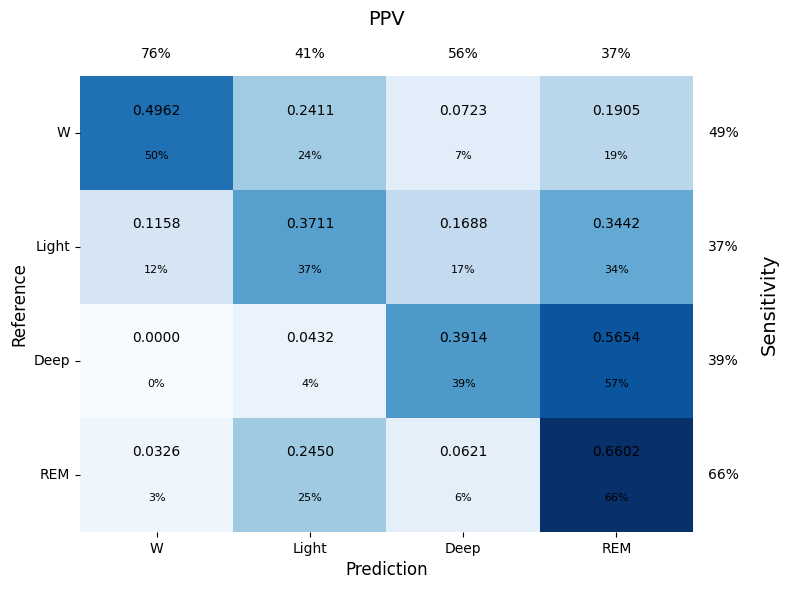

In [23]:
# From previous optuna run
lstm_hidden_size = 256
lstm_num_layers = 2
dropout = 0.30852038514107194
learning_rate = 0.006903453198555122
weight_decay = 3.688273744980673e-05
label_smoothing = 0.016709469700221313

num_runs = 10
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

test_aurocs = []
test_accuracies = []
test_kappas = []
test_confusions = []

for runNo in range(num_runs):
    model = LSTMSleepStager(
        hf_input_channels=len(hf_features),
        lf_input_channels=len(lf_features),
        lstm_hidden_size=lstm_hidden_size,
        lstm_num_layers=lstm_num_layers,
        lstm_bidirectional=True,
        dropout=dropout,
        num_sleep_stages=4,
        learning_rate=learning_rate,
        weight_decay=weight_decay,
        label_smoothing=label_smoothing,
        weight_tensor=torch.tensor(class_weights, dtype=torch.float32),
        debug=False
    )
    model.load_state_dict(torch.load(f'models/LSTM/best_model_{runNo}.pth'))

    test_acc, test_kappa, test_auroc, test_cm = evaluate_model(model, test_loader)
    test_aurocs.append(test_auroc)
    test_accuracies.append(test_acc)
    test_kappas.append(test_kappa)
    test_confusions.append(test_cm)

# print results
print(f"Test AUROC: {np.mean(test_aurocs):.4f} +/- {np.std(test_aurocs):.4f}")
print(f"Test Accuracy: {np.mean(test_accuracies):.4f} +/- {np.std(test_accuracies):.4f}")
print(f"Test Kappa: {np.mean(test_kappas):.4f} +/- {np.std(test_kappas):.4f}")

# get mean confusion matrix
tcn_mean_confusion = np.mean(test_confusions, axis=0)
# display mean confusion matrix
plot_confusion_matrix_with_metrics(test_confusions[-1], class_mapping={0:'W',1:'Light',2:'Deep',3:'REM'})


# TCN Only Approach

## TCN Hyperparameter Optimization

In [ ]:
num_optuna_trials = 100 # not enough to cover every combination, but should be enough to find a good one
study = optuna.create_study(direction="minimize")
study.optimize(tcn_objective, n_trials=num_optuna_trials)
best_trial = study.best_trial

print(f"Best trial: {best_trial.number}")
print(f"Best trial value: {best_trial.value}")
print(f"Best trial params: {best_trial.params}")

[I 2025-04-29 21:48:28,101] Trial 24 finished with value: 1.2368443012237549 and parameters: {'cnn_output_channels': 64, 'dropout': 0.19866418585334414, 'learning_rate': 0.00019700816849326218, 'weight_decay': 1.1606336549334584e-05, 'label_smoothing': 0.11783564587360429, 'num_tcn_blocks': 7, 'tcn_kernel_size': 5}. Best is trial 11 with value: 1.2068884372711182.
/gpfs/data/oermannlab/users/slj9342/.conda/envs/dl4med_25/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /gpfs/data/oermannlab/users/slj9342/.conda/envs/dl4m ...
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/gpfs/data/oermannlab/users/slj9342/.conda/envs/dl4med_25/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /gpfs/data/oermannlab/users/slj9342/dl4med_final_project/checkpoints/TCN/Optuna exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                  | Params | Mode 
------------------------------------------------------------------
0 | cnn             | HFFeatureExtractorTCN | 1.3 M  | train
1 | kappa           | MulticlassCohenKappa  | 0      | train
2 | classifier      | Linear                | 516    | train
3 | train_criterion | CrossEntropyLoss      | 0      | train
4 | val_criterion   | CrossEntropyLoss      | 0      | train
------------------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.030     Total estimated model params size (MB)
64        Modules in train mode
0         Modules in eval mod

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

## Train TCN Only Model

In [ ]:

cnn_output_channels = 16
dropout = 0.3950198226987424
learning_rate = 0.004189358822532961
label_smoothing = 0.006173192017349373
num_tcn_blocks = 8
tcn_kernel_size = 7
weight_decay = 5.955040205462087e-05


num_runs = 10
max_epochs = 50
for runNo in range(num_runs):
    wandb_logger = WandbLogger(
        project="TCN-Sleep-Stager",
        name=f"best-params-{runNo}",
    )
    checkpoint_callback = ModelCheckpoint( # selected model hyperparams by best val loss, now selecting by best val kappa
        monitor='val_cohen_kappa',
        dirpath='checkpoints/TCN/',
        filename='best-checkpoint',
        save_top_k=1,
        mode='max'
    )
    trainer = pl.Trainer(
        max_epochs=max_epochs,
        devices=1,
        accelerator='gpu',
        logger=wandb_logger,
        log_every_n_steps=1,
        precision="16-mixed",
        callbacks=[checkpoint_callback] # not using early stopping for now
    )
    model = ConvSleepStager(
        hf_input_channels=len(hf_features),
        lf_input_channels=len(lf_features),
        cnn_output_channels=cnn_output_channels,
        dropout=dropout,
        num_sleep_stages=4,
        learning_rate=learning_rate,
        weight_decay=weight_decay,
        label_smoothing=label_smoothing,
        weight_tensor=torch.tensor(class_weights, dtype=torch.float32),
        convnet='TCN',
        num_tcn_blocks=num_tcn_blocks,
        tcn_kernel_size=tcn_kernel_size,
        debug=False
    )
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
    trainer.fit(model, train_loader, val_loader)
    wandb.finish()
    clear_output()
    # load best model
    best_model_path = checkpoint_callback.best_model_path
    best_model = ConvSleepStager.load_from_checkpoint(best_model_path)
    # save the model
    torch.save(best_model.state_dict(), f'models/TCN/best_model_{runNo}.pth')


/gpfs/data/oermannlab/users/slj9342/.conda/envs/dl4med_25/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /gpfs/data/oermannlab/users/slj9342/.conda/envs/dl4m ...
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/gpfs/data/oermannlab/users/slj9342/.conda/envs/dl4med_25/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /gpfs/data/oermannlab/users/slj9342/dl4med_final_project/checkpoints/TCN exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                  | Params | Mode 
------------------------------------------------------------------
0 | cnn             | HFFeatureExtractorTCN | 28.8 K | train
1 | kappa           | MulticlassCohenKappa  | 0      | train
2 | classifier      | Linear                | 68     | train
3 | train_criterion | CrossEntropyLoss      | 0      | train
4 | val_criterion   | CrossEntropyLoss      | 0      | train
------------------------------------------------------------------
28.9 K    Trainable params
0         Non-trainable params
28.9 K    Total params
0.116     Total estimated model params size (MB)
64        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

## Test TCN Only Model

In [ ]:
num_runs = 2
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

cnn_output_channels = 16
dropout = 0.3950198226987424
learning_rate = 0.004189358822532961
label_smoothing = 0.006173192017349373
num_tcn_blocks = 8
tcn_kernel_size = 7
weight_decay = 5.955040205462087e-05

test_aurocs = []
test_accuracies = []
test_kappas = []
test_confusions = []

for runNo in range(num_runs):
    model = ConvSleepStager(
        hf_input_channels=len(hf_features),
        lf_input_channels=len(lf_features),
        cnn_output_channels=cnn_output_channels,
        dropout=dropout,
        num_sleep_stages=4,
        learning_rate=learning_rate,
        weight_decay=weight_decay,
        label_smoothing=label_smoothing,
        weight_tensor=torch.tensor(class_weights, dtype=torch.float32),
        convnet='TCN',
        num_tcn_blocks=num_tcn_blocks,
        tcn_kernel_size=tcn_kernel_size,
        debug=False
    )
    model.load_state_dict(torch.load(f'models/TCN/best_model_{runNo}.pth'))

    test_acc, test_kappa, test_auroc, test_cm = evaluate_model(model, test_loader)
    test_aurocs.append(test_auroc)
    test_accuracies.append(test_acc)
    test_kappas.append(test_kappa)
    test_confusions.append(test_cm)

# print results
print(f"Test AUROC: {np.mean(test_aurocs):.4f} +/- {np.std(test_aurocs):.4f}")
print(f"Test Accuracy: {np.mean(test_accuracies):.4f} +/- {np.std(test_accuracies):.4f}")
print(f"Test Kappa: {np.mean(test_kappas):.4f} +/- {np.std(test_kappas):.4f}")

# display mean confusion matrix
plot_confusion_matrix_with_metrics(test_confusions[-1], class_mapping={0:'W',1:'Light',2:'Deep',3:'REM'})


# TCN-LSTM Approach

## TCN-LSTM Hyperparameter Optimization

In [ ]:
num_optuna_trials = 100 # not enough to cover every combination, but should be enough to find a good one
study = optuna.create_study(direction="minimize")
study.optimize(tcn_lstm_objective, n_trials=num_optuna_trials)
best_trial = study.best_trial

print(f"Best trial: {best_trial.number}")
print(f"Best trial value: {best_trial.value}")
print(f"Best trial params: {best_trial.params}")

## Train TCN-LSTM Model

In [ ]:
cnn_output_channels = 16
dropout = 0.21312
label_smoothing = 0.0050416
learning_rate = 0.0048844
lstm_hidden_size = 256
lstm_num_layers = 2
num_tcn_blocks = 7
tcn_kernel_size = 5
weight_decay = 0.0000078942


num_runs = 10
max_epochs = 50
for runNo in range(num_runs):
    wandb_logger = WandbLogger(
        project="TCN-LSTM-Sleep-Stager",
        name=f"best-params-{runNo}",
    )
    checkpoint_callback = ModelCheckpoint( # selected model hyperparams by best val loss, now selecting by best val kappa
        monitor='val_cohen_kappa',
        dirpath='checkpoints/TCN-LSTM/',
        filename='best-checkpoint',
        save_top_k=1,
        mode='max'
    )
    early_stop_callback = EarlyStopping(
        monitor='val_cohen_kappa',
        patience=10,
        verbose=True,
        mode='max'
    )
    trainer = pl.Trainer(
        max_epochs=max_epochs,
        devices=1,
        accelerator='gpu',
        logger=wandb_logger,
        log_every_n_steps=1,
        precision="16-mixed",
        #callbacks=[checkpoint_callback, early_stop_callback]
        callbacks=[checkpoint_callback] # not using early stopping for now
    )
    model = DualFreqSleepStager(
        hf_input_channels=len(hf_features),
        lf_input_channels=len(lf_features),
        cnn_output_channels=cnn_output_channels,
        lstm_hidden_size=lstm_hidden_size,
        lstm_num_layers=lstm_num_layers,
        lstm_bidirectional=True,
        dropout=dropout,
        num_sleep_stages=4,
        learning_rate=learning_rate,
        weight_decay=weight_decay,
        label_smoothing=label_smoothing,
        weight_tensor=torch.tensor(class_weights, dtype=torch.float32),
        convnet='TCN',
        num_tcn_blocks=num_tcn_blocks,
        tcn_kernel_size=tcn_kernel_size,
        debug=False
    )
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
    trainer.fit(model, train_loader, val_loader)
    wandb.finish()
    clear_output()
    # load best model
    best_model_path = checkpoint_callback.best_model_path
    best_model = DualFreqSleepStager.load_from_checkpoint(best_model_path)
    # save the model
    torch.save(best_model.state_dict(), f'models/TCN-LSTM/best_model_{runNo}.pth')

## Test TCN-LSTM Model

In [ ]:
num_runs = 10
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

cnn_output_channels = 16
dropout = 0.21312
label_smoothing = 0.0050416
learning_rate = 0.0048844
lstm_hidden_size = 256
lstm_num_layers = 2
num_tcn_blocks = 7
tcn_kernel_size = 5
weight_decay = 0.0000078942



test_aurocs = []
test_accuracies = []
test_kappas = []
test_confusions = []

for runNo in range(num_runs):
    model = DualFreqSleepStager(
        hf_input_channels=len(hf_features),
        lf_input_channels=len(lf_features),
        cnn_output_channels=cnn_output_channels,
        lstm_hidden_size=lstm_hidden_size,
        lstm_num_layers=lstm_num_layers,
        lstm_bidirectional=True,
        dropout=dropout,
        num_sleep_stages=4,
        learning_rate=learning_rate,
        weight_decay=weight_decay,
        label_smoothing=label_smoothing,
        weight_tensor=torch.tensor(class_weights, dtype=torch.float32),
        convnet='TCN',
        num_tcn_blocks=num_tcn_blocks,
        tcn_kernel_size=tcn_kernel_size,
        debug=False
    )
    model.load_state_dict(torch.load(f'models/TCN-LSTM/best_model_{runNo}.pth'))

    test_acc, test_kappa, test_auroc, test_cm = evaluate_model(model, test_loader)
    test_aurocs.append(test_auroc)
    test_accuracies.append(test_acc)
    test_kappas.append(test_kappa)
    test_confusions.append(test_cm)

# print results
print(f"Test AUROC: {np.mean(test_aurocs):.4f} +/- {np.std(test_aurocs):.4f}")
print(f"Test Accuracy: {np.mean(test_accuracies):.4f} +/- {np.std(test_accuracies):.4f}")
print(f"Test Kappa: {np.mean(test_kappas):.4f} +/- {np.std(test_kappas):.4f}")

# get mean confusion matrix
tcn_mean_confusion = np.mean(test_confusions, axis=0)
# display mean confusion matrix
plot_confusion_matrix_with_metrics(test_confusions[-1], class_mapping={0:'W',1:'Light',2:'Deep',3:'REM'})


# CNN-LSTM Approach

## CNN-LSTM Hyperparameter Optimization

In [ ]:
num_optuna_trials = 100 # not enough to cover every combination, but should be enough to find a good one
study = optuna.create_study(direction="minimize")
study.optimize(cnn_objective, n_trials=num_optuna_trials)
best_trial = study.best_trial
clear_output()
print(f"Best trial: {best_trial.number}")
print(f"Best trial value: {best_trial.value}")
print(f"Best trial params: {best_trial.params}")


## Train and Test CNN model

### Train CNN Model

In [ ]:
'''cnn_output_channels = best_trial.params['cnn_output_channels']
lstm_hidden_size = best_trial.params['lstm_hidden_size']
num_layers = best_trial.params['num_layers']
dropout = best_trial.params['dropout']
learning_rate = best_trial.params['learning_rate']
weight_decay = best_trial.params['weight_decay']
label_smoothing = best_trial.params['label_smoothing']
'''
cnn_output_channels = 64
lstm_hidden_size = 256
lstm_num_layers = 6
dropout = 0.3348076952070481
learning_rate = 0.0010265829979403838
weight_decay = 4.969225017183202e-06
label_smoothing = 0.12009173751056051


test_aurocs = []
test_accuracies = []
test_kappas = []
test_confusions = []

num_runs = 10
max_epochs = 50
for runNo in range(num_runs):
    wandb_logger = WandbLogger(
        project="CNN-LSTM-Dual-Freq-Sleep-Stager",
        name=f"best-params-{runNo}",
    )
    checkpoint_callback = ModelCheckpoint(
        monitor='val_cohen_kappa',
        dirpath='checkpoints/CNN-LSTM/',
        filename='best-checkpoint',
        save_top_k=1,
        mode='max'
    )
    early_stop_callback = EarlyStopping(
        monitor='val_cohen_kappa',
        patience=10,
        verbose=True,
        mode='max'
    )
    trainer = pl.Trainer(
        max_epochs=max_epochs,
        devices=1,
        accelerator='gpu',
        logger=wandb_logger,
        log_every_n_steps=1,
        precision="16-mixed",
        #callbacks=[checkpoint_callback, early_stop_callback]
        callbacks=[checkpoint_callback] # not using early stopping for now
    )
    model = DualFreqSleepStager(
        hf_input_channels=len(hf_features),
        lf_input_channels=len(lf_features),
        cnn_output_channels=cnn_output_channels,
        lstm_hidden_size=lstm_hidden_size,
        lstm_num_layers=lstm_num_layers,
        lstm_bidirectional=True,
        dropout=dropout,
        num_sleep_stages=4,
        learning_rate=learning_rate,
        weight_decay=weight_decay,
        label_smoothing=label_smoothing,
        weight_tensor=torch.tensor(class_weights, dtype=torch.float32),
        convnet='CNN',
        debug=False
    )
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
    trainer.fit(model, train_loader, val_loader)
    wandb.finish()
    clear_output()
    # load best model
    best_model_path = checkpoint_callback.best_model_path
    best_model = DualFreqSleepStager.load_from_checkpoint(best_model_path)

    # test the model
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

    test_acc, test_kappa, test_auroc, test_cm = evaluate_model(best_model, test_loader)
    test_aurocs.append(test_auroc)
    test_accuracies.append(test_acc)
    test_kappas.append(test_kappa)
    test_confusions.append(test_cm)

    # save the model
    torch.save(best_model.state_dict(), f'models/CNN-LSTM/best_model_{runNo}.pth')


print(f"Test AUROC: {np.mean(test_aurocs):.4f} +/- {np.std(test_aurocs):.4f}")
print(f"Test Accuracy: {np.mean(test_accuracies):.4f} +/- {np.std(test_accuracies):.4f}")
print(f"Test Kappa: {np.mean(test_kappas):.4f} +/- {np.std(test_kappas):.4f}")

# get mean confusion matrix
cnn_mean_confusion = np.mean(test_confusions, axis=0)
# display mean confusion matrix
plot_confusion_matrix(cnn_mean_confusion, classes=['W','N1','N2','N3','R'])


### Test CNN Model

In [ ]:
num_runs = 10
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

cnn_output_channels = 64
lstm_hidden_size = 256
lstm_num_layers = 6
dropout = 0.3348076952070481
learning_rate = 0.0010265829979403838
weight_decay = 4.969225017183202e-06
label_smoothing = 0.12009173751056051


test_aurocs = []
test_accuracies = []
test_kappas = []
test_confusions = []

for runNo in range(num_runs):
    model = DualFreqSleepStager(
        hf_input_channels=len(hf_features),
        lf_input_channels=len(lf_features),
        cnn_output_channels=cnn_output_channels,
        lstm_hidden_size=lstm_hidden_size,
        lstm_num_layers=lstm_num_layers,
        lstm_bidirectional=True,
        dropout=dropout,
        num_sleep_stages=4,
        learning_rate=learning_rate,
        weight_decay=weight_decay,
        label_smoothing=label_smoothing,
        weight_tensor=torch.tensor(class_weights, dtype=torch.float32),
        convnet='CNN',
        debug=False
    )
    model.load_state_dict(torch.load(f'models/CNN-LSTM/best_model_{runNo}.pth'))
    test_acc, test_kappa, test_auroc, test_cm = evaluate_model(model, test_loader)
    test_aurocs.append(test_auroc)
    test_accuracies.append(test_acc)
    test_kappas.append(test_kappa)
    test_confusions.append(test_cm)

print(f"Test AUROC: {np.mean(test_aurocs):.4f} +/- {np.std(test_aurocs):.4f}")
print(f"Test Accuracy: {np.mean(test_accuracies):.4f} +/- {np.std(test_accuracies):.4f}")
print(f"Test Kappa: {np.mean(test_kappas):.4f} +/- {np.std(test_kappas):.4f}")

# get mean confusion matrix
cnn_mean_confusion = np.mean(test_confusions, axis=0)
# display last confusion matrix
#plot_confusion_matrix(test_confusions[-1,:,:], classes=['W','N1','N2','N3','R'])
plot_confusion_matrix_with_metrics(test_confusions[-1], class_mapping={0:'W',1:'Light',2:'Deep',3:'REM'})



# Compare Inference Times

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
temp_hf, temp_lf, temp_labels = train_dataset[0]
temp_hf = temp_hf.unsqueeze(0).to(device)
temp_lf = temp_lf.unsqueeze(0).to(device)
# LSTM Only
lstm_hidden_size = 256
lstm_num_layers = 2
dropout = 0.21312
learning_rate = 0.0048844
weight_decay = 0.0000078942
label_smoothing = 0.0050416
lstm_model = LSTMSleepStager(
        hf_input_channels=len(hf_features),
        lf_input_channels=len(lf_features),
        lstm_hidden_size=lstm_hidden_size,
        lstm_num_layers=lstm_num_layers,
        lstm_bidirectional=True,
        dropout=dropout,
        num_sleep_stages=4,
        learning_rate=learning_rate,
        weight_decay=weight_decay,
        label_smoothing=label_smoothing,
        weight_tensor=torch.tensor(class_weights, dtype=torch.float32),
        debug=False
    )
lstm_model.eval()
lstm_model.to(device)

# CNN-LSTM
cnn_output_channels = 64
lstm_hidden_size = 256
lstm_num_layers = 6
dropout = 0.3348076952070481
learning_rate = 0.0010265829979403838
weight_decay = 4.969225017183202e-06
label_smoothing = 0.12009173751056051

cnn_model = DualFreqSleepStager(
        hf_input_channels=len(hf_features),
        lf_input_channels=len(lf_features),
        cnn_output_channels=cnn_output_channels,
        lstm_hidden_size=lstm_hidden_size,
        lstm_num_layers=lstm_num_layers,
        lstm_bidirectional=True,
        dropout=dropout,
        num_sleep_stages=4,
        learning_rate=learning_rate,
        weight_decay=weight_decay,
        label_smoothing=label_smoothing,
        weight_tensor=torch.tensor(class_weights, dtype=torch.float32),
        convnet='CNN',
        debug=False
    )
cnn_model.eval()
cnn_model.to(device)

# TCN-LSTM
cnn_output_channels = 16
dropout = 0.21312
label_smoothing = 0.0050416
learning_rate = 0.0048844
lstm_hidden_size = 256
lstm_num_layers = 2
num_tcn_blocks = 7
tcn_kernel_size = 5
weight_decay = 0.0000078942

tcn_model = DualFreqSleepStager(
        hf_input_channels=len(hf_features),
        lf_input_channels=len(lf_features),
        cnn_output_channels=cnn_output_channels,
        lstm_hidden_size=lstm_hidden_size,
        lstm_num_layers=lstm_num_layers,
        lstm_bidirectional=True,
        dropout=dropout,
        num_sleep_stages=4,
        learning_rate=learning_rate,
        weight_decay=weight_decay,
        label_smoothing=label_smoothing,
        weight_tensor=torch.tensor(class_weights, dtype=torch.float32),
        convnet='TCN',
        num_tcn_blocks=num_tcn_blocks,
        tcn_kernel_size=tcn_kernel_size,
        debug=False
    )
tcn_model.eval()
tcn_model.to(device)

lstm_times = []
cnn_times = []
tcn_times = []
num_trials = 100
with torch.no_grad():
    # warm up
    for _ in range(10):
        cnn_model(temp_hf, temp_lf)
        tcn_model(temp_hf, temp_lf)
    torch.cuda.synchronize()
    # measure time
    start = time.time()
    for _ in range(num_trials):
        cnn_model(temp_hf, temp_lf)
        torch.cuda.synchronize()
    end = time.time()
    cnn_times.append((end - start) / 100)

    start = time.time()
    for _ in range(num_trials):
        tcn_model(temp_hf, temp_lf)
        torch.cuda.synchronize()
    end = time.time()
    tcn_times.append((end - start) / 100)

    start = time.time()
    for _ in range(num_trials):
        lstm_model(temp_hf, temp_lf)
        torch.cuda.synchronize()
    end = time.time()
    lstm_times.append((end - start) / 100)
print(f"cnn time: {np.mean(cnn_times):.4f} +/- {np.std(cnn_times):.4f}")
print(f"tcn time: {np.mean(tcn_times):.4f} +/- {np.std(tcn_times):.4f}")
print(f"lstm time: {np.mean(lstm_times):.4f} +/- {np.std(lstm_times):.4f}")
